In [0]:
import os
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import classification_report
from collections import Counter
import visualkeras
from PIL import ImageFont

--------------------------------------------------------------------------- 
 ModuleNotFoundError Traceback (most recent call last)
 <command-556958884330244> in <module> 
 16 from sklearn . metrics import classification_report
 17 from collections import Counter
 ---> 18 import visualkeras
 19 from PIL import ImageFont

 /databricks/python_shell/dbruntime/PythonPackageImportsInstrumentation/__init__.py in import_patch (name, globals, locals, fromlist, level) 
 165 # Import the desired module. If you’re seeing this while debugging a failed import, 
 166 # look at preceding stack frames for relevant error information. 
 --> 167 original_result = python_builtin_import ( name , globals , locals , fromlist , level ) 
 168 
 169 is_root_import = thread_local . _nest_level == 1 

 ModuleNotFoundError : No module named 'visualkeras'

In [0]:
container ="data1"
data_path = f"abfss://{container}@capstone2023cuhk.dfs.core.windows.net/"
df = spark.read.csv(os.path.join(data_path, "AML-data", "Actual_Data_2021-2022", "ITEM_MATCHING_2021_BOOKS.csv"), header=True)
df2 = spark.read.csv(os.path.join(data_path, "AML-data", "Actual_Data_2021-2022", "ITEM_MATCHING_2022_BOOKS.csv"), header=True)
df = df.toPandas()
df2 = df2.toPandas()
df = df.loc[df['PRICE']!='0']
df = df.loc[df['QTY_SALES']!='0']
df2 = df2.loc[df2['PRICE']!='0']
df2 = df2.loc[df2['QTY_SALES']!='0']
# df.loc[df['QTY_SALES']=='MBI       ']
df = df.drop(index=[583])

In [0]:
VENDORList = set(df['VENDOR'].str.strip().unique()) & set(df2['VENDOR'].str.strip().unique())
df = df[df['VENDOR'].str.strip().isin(VENDORList)]
df2 = df2[df2['VENDOR'].str.strip().isin(VENDORList)]

In [0]:
BRANDList = set(df['BRAND'].str.strip().unique()) & set(df2['BRAND'].str.strip().unique())
df = df[df['BRAND'].str.strip().isin(BRANDList)]
df2 = df2[df2['BRAND'].str.strip().isin(BRANDList)]

In [0]:
PRD_CATEGORYList = set(df['PRD_CATEGORY'].str.strip().unique()) & set(df2['PRD_CATEGORY'].str.strip().unique())
df = df[df['PRD_CATEGORY'].str.strip().isin(PRD_CATEGORYList)]
df2 = df2[df2['PRD_CATEGORY'].str.strip().isin(PRD_CATEGORYList)]

In [0]:
PRD_ORIGINList = set(df['PRD_ORIGIN'].str.strip().unique()) & set(df2['PRD_ORIGIN'].str.strip().unique())
df = df[df['PRD_ORIGIN'].str.strip().isin(PRD_ORIGINList)]
df2 = df2[df2['PRD_ORIGIN'].str.strip().isin(PRD_ORIGINList)]

In [0]:
PUBLISHERList = set(df['PUBLISHER'].str.strip().unique()) & set(df2['PUBLISHER'].str.strip().unique())
df = df[df['PUBLISHER'].str.strip().isin(PUBLISHERList)]
df2 = df2[df2['PUBLISHER'].str.strip().isin(PUBLISHERList)]

In [0]:
df2 = df2.loc[df2['BRAND']!='S-ZONE  ']
df2 = df2.loc[df2['VENDOR']!='HINKLER   ']

In [0]:
def categorizeSales(threshold, n):
    return 1.0 if n >= threshold else 0.0

In [0]:
df3 = df[['COST','PRICE', 'QTY_SALES','VENDOR','BRAND','PRD_CATEGORY','PRD_ORIGIN','PUBLISHER']]
df3

Out[9]:

,COST,PRICE,QTY_SALES,VENDOR,BRAND,PRD_CATEGORY,PRD_ORIGIN,PUBLISHER
1,13.74,59.00,137,HINKLER,HINKLER,J&C,USA,HINKLER
2,13.35,59.00,206,HINKLER,HINKLER,J&C,USA,HINKLER
3,29.44,119.00,50,HINKLER,HINKLER,G/S,USA,HINKLER
4,29.44,129.00,204,HINKLER,HINKLER,G/S,AUS,HINKLER
5,29.44,129.00,195,HINKLER,HINKLER,G/S,AUS,HINKLER
...,...,...,...,...,...,...,...,...
1748,28.73,119.00,12,LAKE-US$,LAKE,A&C,AUS,LAKE
1749,11.46,49.00,21,LAKE-US$,LAKE,ACT,AUS,LAKE
1750,11.46,49.00,22,LAKE-US$,LAKE,ACT,AUS,LAKE
1751,14.92,59.00,4,LAKE-US$,LAKE,NVT,AUS,LAKE


In [0]:
df3['COST'] = pd.to_numeric(df['COST'], errors='coerce')
df3 = df3.dropna(subset=['COST'])
df3['COST'] = df3['COST'].astype(float)
df3['PRICE'] = df3['PRICE'].astype(float)
df3['QTY_SALES'] = df3['QTY_SALES'].astype(float)
df3["QTY_SALES"] = minmax_scale(df3["QTY_SALES"], feature_range=(0, 1), axis=0, copy=True)
df3 = pd.get_dummies(df3, prefix="cat", 
                            columns=["VENDOR","BRAND","PRD_CATEGORY","PRD_ORIGIN","PUBLISHER"], 
                            drop_first=False)

<command-556958884330253>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 df3['COST'] = pd.to_numeric(df['COST'], errors='coerce')
<command-556958884330253>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 df3['COST'] = df3['COST'].astype(float)
<command-556958884330253>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 df3['PRICE'] = df3['PRICE'].astype(float)
<command-556958884330253>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 df3['QTY_SALES'] = df3['QTY_SALES'].astype(float)
<command-556958884330253>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 df3["QTY_SALES"] = minmax_scale(df3["QTY_SALES"], feature_range=(0, 1), axis=0, copy=True)

In [0]:
#define trainging data set and testing data set
training_data, testing_data = train_test_split(df3, test_size=0.2, random_state=25)

In [0]:
threshold = 0.3
x_data = training_data.drop(labels=['QTY_SALES'],axis=1)
y_data = training_data['QTY_SALES'].apply(lambda x: categorizeSales(threshold, x))
x_data_test = testing_data.drop(labels=['QTY_SALES'],axis=1)
y_data_test = testing_data['QTY_SALES'].apply(lambda x: categorizeSales(threshold, x))

In [0]:
x_data

Out[18]:

,COST,PRICE,cat_66-BOOKS,cat_AOL,cat_CAPSTONE,cat_CDP,cat_CENTUM,cat_GBS,cat_HC,cat_HC-USA,cat_HINKLER,cat_HINKLER-U,cat_IGLOO-US$,cat_KUMON,cat_LAKE-US$,cat_MBI,cat_MBI-US$,cat_MML,cat_MPS,cat_NPP,cat_PE-USA,cat_PHIDAL,cat_PI,cat_RH,cat_RIVERSIDE,cat_S&S,cat_SASSI,cat_SL,cat_SL-MALAY,cat_TBS,cat_WORKMAN,cat_ANDREWS,cat_AUTUMN,cat_BBY,cat_CAMPBELL,cat_CAPSTONE,cat_CDP,cat_CENTUM,cat_CHRONI'L,cat_DK(USA),...,cat_USA,cat_,cat_ANDREWS,cat_AUTUMN,cat_BLOOMSBURY,cat_CAMPBELL,cat_CAPSTONE,cat_CDP,cat_CENTUM,cat_CHRONICLE,cat_DK(USA),cat_EGM,cat_HC,cat_HC-USA,cat_HINKLER,cat_HODDER,cat_IGLOO,cat_KLUTZ,cat_KUMON,cat_L-BROWN,cat_LAKE,cat_LB,cat_MBI,cat_MML,cat_MML-C,cat_MML-USA,cat_NPP,cat_ORCHARD-UK,cat_PENGUIN,cat_PHIDAL,cat_PI,cat_PUFFIN,cat_RH,cat_S&S,cat_SASSI,cat_SL,cat_SL-UK,cat_UB,cat_WALKER,cat_WORKMAN
555,13.78,49.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
383,43.15,219.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
193,30.59,129.9,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
332,24.11,105.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
265,141.28,599.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,63.78,249.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
239,15.68,79.9,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
688,21.12,89.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
436,63.78,249.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [0]:
model = keras.models.Sequential()
model.add(layers.Dense(512, activation='relu',input_dim=x_data.shape[1]))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss=keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])

In [0]:
image = visualkeras.layered_view(model, legend=True)

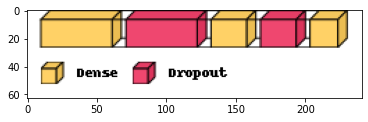

In [0]:
imgplot = plt.imshow(image)
plt.show()

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type) Output Shape Param # 
=================================================================
 dense (Dense) (None, 512) 78336 
 
 dropout (Dropout) (None, 512) 0 
 
 dense_1 (Dense) (None, 256) 131328 
 
 dropout_1 (Dropout) (None, 256) 0 
 
 dense_2 (Dense) (None, 1) 257 
 
=================================================================
Total params: 209,921
Trainable params: 209,921
Non-trainable params: 0
_________________________________________________________________

In [0]:
len(x_data),len(y_data)

Out[27]: (764, 764)

In [0]:
model.fit(x=x_data, y=y_data, epochs=100)

Epoch 1/100
 1/24 [>.............................] - ETA: 15s - loss: 2.2597 - accuracy: 0.375018/24 [=====================>........] - ETA: 0s - loss: 1.3123 - accuracy: 0.9427 24/24 [==============================] - 1s 13ms/step - loss: 1.1137 - accuracy: 0.9516
Epoch 2/100
 1/24 [>.............................] - ETA: 0s - loss: 0.0080 - accuracy: 1.000019/24 [======================>.......] - ETA: 0s - loss: 0.4298 - accuracy: 0.944124/24 [==============================] - 0s 3ms/step - loss: 0.4596 - accuracy: 0.9490
Epoch 3/100
 1/24 [>.............................] - ETA: 0s - loss: 0.9215 - accuracy: 0.937518/24 [=====================>........] - ETA: 0s - loss: 0.3403 - accuracy: 0.954924/24 [==============================] - 0s 3ms/step - loss: 0.3436 - accuracy: 0.9594
Epoch 4/100
 1/24 [>.............................] - ETA: 0s - loss: 0.0355 - accuracy: 1.000019/24 [======================>.......] - ETA: 0s - loss: 0.3056 - accuracy: 0.958924/24 [==============================] - 0s 3ms/step - loss: 0.3150 - accuracy: 0.9516
Epoch 5/100
 1/24 [>.............................] - ETA: 0s - loss: 0.3202 - accuracy: 0.968820/24 [========================>.....] - ETA: 0s - loss: 0.2811 - accuracy: 0.967224/24 [==============================] - 0s 3ms/step - loss: 0.2816 - accuracy: 0.9673
Epoch 6/100
 1/24 [>.............................] - ETA: 0s - loss: 0.0447 - accuracy: 1.000015/24 [=================>............] - ETA: 0s - loss: 0.2735 - accuracy: 0.975024/24 [==============================] - 0s 4ms/step - loss: 0.2384 - accuracy: 0.9686
Epoch 7/100
 1/24 [>.............................] - ETA: 0s - loss: 0.0630 - accuracy: 1.000020/24 [========================>.....] - ETA: 0s - loss: 0.2048 - accuracy: 0.971924/24 [==============================] - 0s 3ms/step - loss: 0.2192 - accuracy: 0.9712
Epoch 8/100
 1/24 [>.............................] - ETA: 0s - loss: 0.2965 - accuracy: 0.968820/24 [========================>.....] - ETA: 0s - loss: 0.2261 - accuracy: 0.970324/24 [==============================] - 0s 3ms/step - loss: 0.2388 - accuracy: 0.9699
Epoch 9/100
 1/24 [>.............................] - ETA: 0s - loss: 0.6020 - accuracy: 0.937520/24 [========================>.....] - ETA: 0s - loss: 0.2449 - accuracy: 0.967224/24 [==============================] - 0s 3ms/step - loss: 0.2349 - accuracy: 0.9673
Epoch 10/100
 1/24 [>.............................] - ETA: 0s - loss: 0.2431 - accuracy: 0.9688

In [0]:
len(x_data_test) , len(y_data_test)

Out[29]: (192, 192)

In [0]:
score, acc = model.evaluate(x_data_test, y_data_test)
print('Test score:', score)
print('Test accuracy:', acc)

1/6 [====>.........................] - ETA: 0s - loss: 0.2501 - accuracy: 0.93756/6 [==============================] - 0s 2ms/step - loss: 0.1690 - accuracy: 0.9635
Test score: 0.16900961101055145
Test accuracy: 0.9635416865348816

In [0]:
df4 = df2[['COST','PRICE','VENDOR','BRAND','PRD_CATEGORY','PRD_ORIGIN','PUBLISHER','QTY_SALES']]
df4['COST'] = pd.to_numeric(df2['COST'], errors='coerce')
df4 = df4.dropna(subset=['COST'])
df4['COST'] = df4['COST'].astype(float)
df4['PRICE'] = df4['PRICE'].astype(float)
df4 = pd.get_dummies(df4, prefix="cat", columns=["VENDOR","BRAND","PRD_CATEGORY","PRD_ORIGIN","PUBLISHER"], drop_first=False)
df4['QTY_SALES'] = minmax_scale(df4["QTY_SALES"], feature_range=(0, 1), axis=0, copy=True)

<command-556958884330262>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 df4['COST'] = pd.to_numeric(df2['COST'], errors='coerce')

In [0]:
y = df4['QTY_SALES'].apply(lambda x: categorizeSales(threshold, x))
x = df4.loc[:, ~df4.columns.isin(['QTY_SALES'])]

In [0]:
score, acc = model.evaluate(x, y)
print('Test score:', score)
print('Test accuracy:', acc)

1/36 [..............................] - ETA: 4s - loss: 0.0103 - accuracy: 1.000020/36 [===============>..............] - ETA: 0s - loss: 0.1239 - accuracy: 0.992236/36 [==============================] - 0s 2ms/step - loss: 0.1438 - accuracy: 0.9894
Test score: 0.14380420744419098
Test accuracy: 0.989371120929718

In [0]:
y_pred = np.round(model.predict(x))
y_pred = y_pred.astype("float64")

In [0]:
np.nanmax(y_pred)

Out[35]: 0.0

In [0]:
y

Out[26]: 0 0.0
10 0.0
11 0.0
12 0.0
13 0.0
 ... 
1520 0.0
1521 0.0
1522 0.0
1523 0.0
1524 0.0
Name: QTY_SALES, Length: 1129, dtype: float64

In [0]:
target_names = ['class 0', 'class 1']
print(classification_report(y, y_pred, target_names=target_names))

/databricks/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 _warn_prf(average, modifier, msg_start, len(result))
 precision recall f1-score support

 class 0 0.99 1.00 0.99 1117
 class 1 0.00 0.00 0.00 12

 accuracy 0.99 1129
 macro avg 0.49 0.50 0.50 1129
weighted avg 0.98 0.99 0.98 1129

In [0]:
def runModel(df_train, df_test, model ,threshold,accuracy):
    x_train = df_train.drop(labels=['QTY_SALES'],axis=1)
    y_train = df_train["QTY_SALES"].apply(lambda x: categorizeSales(threshold, x))

    x_test = df_test.drop(labels=['QTY_SALES'],axis=1)
    y_test = df_test["QTY_SALES"].apply(lambda x: categorizeSales(threshold, x))

    model.fit(x=x_train, y=y_train, epochs=100,verbose=0)

    score, acc = model.evaluate(x_test, y_test)
    print("Threshold: {}".format(str(threshold)))
    print('Test score:', score)
    print('Test accuracy:', acc)
    target_names = ['class 0', 'class 1']

    y_train_pred = np.round(model.predict(x_train))
    y_train_pred = y_train_pred.astype("float64")
    print(classification_report(y_train, y_train_pred, target_names=target_names))

    y_pred = np.round(model.predict(x_test))
    y_pred = y_pred.astype("float64")
    print(classification_report(y_test, y_pred, target_names=target_names))

    accuracy= accuracy.append(acc)

In [0]:
accuracy = []
for t in range(1, 15):
    threshold = t/100
    runModel(df3, df4,model,threshold,accuracy)

INFO:tensorflow:Assets written to: /tmp/tmpao10tigx/model/data/model/assets
 1/36 [..............................] - ETA: 0s - loss: 1.1107 - accuracy: 0.718827/36 [=====================>........] - ETA: 0s - loss: 0.4617 - accuracy: 0.861136/36 [==============================] - 0s 2ms/step - loss: 0.4682 - accuracy: 0.8707
Threshold: 0.01
Test score: 0.46815359592437744
Test accuracy: 0.8706820011138916
 precision recall f1-score support

 class 0 0.75 0.41 0.53 111
 class 1 0.93 0.98 0.95 845

 accuracy 0.92 956
 macro avg 0.84 0.69 0.74 956
weighted avg 0.91 0.92 0.90 956

 precision recall f1-score support

 class 0 0.10 0.02 0.04 122
 class 1 0.89 0.97 0.93 1007

 accuracy 0.87 1129
 macro avg 0.50 0.50 0.49 1129
weighted avg 0.81 0.87 0.83 1129

INFO:tensorflow:Assets written to: /tmp/tmpytwd_ly0/model/data/model/assets
 1/36 [..............................] - ETA: 0s - loss: 1.4723 - accuracy: 0.500029/36 [=======================>......] - ETA: 0s - loss: 0.9309 - accuracy: 0.683236/36 [==============================] - 0s 2ms/step - loss: 0.8964 - accuracy: 0.6891
Threshold: 0.02
Test score: 0.8963572978973389
Test accuracy: 0.6891053915023804
 precision recall f1-score support

 class 0 0.85 0.70 0.77 302
 class 1 0.87 0.94 0.91 654

 accuracy 0.87 956
 macro avg 0.86 0.82 0.84 956
weighted avg 0.86 0.87 0.86 956

 precision recall f1-score support

 class 0 0.46 0.36 0.40 331
 class 1 0.76 0.83 0.79 798

 accuracy 0.69 1129
 macro avg 0.61 0.59 0.60 1129
weighted avg 0.67 0.69 0.68 1129

INFO:tensorflow:Assets written to: /tmp/tmp6xkqzeh8/model/data/model/assets
 1/36 [..............................] - ETA: 0s - loss: 1.4203 - accuracy: 0.437529/36 [=======================>......] - ETA: 0s - loss: 0.9682 - accuracy: 0.667036/36 [==============================] - 0s 2ms/step - loss: 1.0268 - accuracy: 0.6572
Threshold: 0.03
Test score: 1.0268242359161377
Test accuracy: 0.6572187542915344
 precision recall f1-score support

 class 0 0.88 0.72 0.79 492
 class 1 0.75 0.90 0.82 464

 accuracy 0.81 956
 macro avg 0.82 0.81 0.81 956
weighted avg 0.82 0.81 0.81 956

 precision recall f1-score support

 class 0 0.66 0.61 0.64 550
 class 1 0.66 0.70 0.68 579

 accuracy 0.66 1129
 macro avg 0.66 0.66 0.66 1129
weighted avg 0.66 0.66 0.66 1129

INFO:tensorflow:Assets written to: /tmp/tmp3lj52qm2/model/data/model/assets
 1/36 [..............................] - ETA: 0s - loss: 0.6277 - accuracy: 0.656229/36 [=======================>......] - ETA: 0s - loss: 0.8847 - accuracy: 0.655236/36 [==============================] - 0s 2ms/step - loss: 1.0085 - accuracy: 0.6377
Threshold: 0.04
Test score: 1.0085152387619019
Test accuracy: 0.6377325057983398
 precision recall f1-score support

 class 0 0.84 0.88 0.86 617
 class 1 0.77 0.70 0.73 339

 accuracy 0.82 956
 macro avg 0.81 0.79 0.80 956
weighted avg 0.82 0.82 0.82 956

 precision recall f1-score support

 class 0 0.67 0.79 0.72 684
 class 1 0.55 0.41 0.47 445

 accuracy 0.64 1129
 macro avg 0.61 0.60 0.60 1129
weighted avg 0.63 0.64 0.62 1129

INFO:tensorflow:Assets written to: /tmp/tmpaf0bzwo0/model/data/model/assets
 1/36 [..............................] - ETA: 0s - loss: 0.6279 - accuracy: 0.812529/36 [=======================>......] - ETA

In [0]:
df4["QTY_SALES"]

Out[30]: 0 0.000929
10 0.023213
11 0.007428
12 0.008357
13 0.007428
 ... 
1520 0.014856
1521 0.016713
1522 0.015785
1523 0.020427
1524 0.027855
Name: QTY_SALES, Length: 1129, dtype: float64

In [0]:
for t in range(1, 30):
    threshold = t/100
    temp = df3["QTY_SALES"].apply(lambda x: categorizeSales(threshold, x))
    print(threshold)
    print(Counter(temp))

0.01
Counter({1.0: 845, 0.0: 111})
0.02
Counter({1.0: 654, 0.0: 302})
0.03
Counter({0.0: 492, 1.0: 464})
0.04
Counter({0.0: 617, 1.0: 339})
0.05
Counter({0.0: 695, 1.0: 261})
0.06
Counter({0.0: 753, 1.0: 203})
0.07
Counter({0.0: 802, 1.0: 154})
0.08
Counter({0.0: 823, 1.0: 133})
0.09
Counter({0.0: 844, 1.0: 112})
0.1
Counter({0.0: 855, 1.0: 101})
0.11
Counter({0.0: 868, 1.0: 88})
0.12
Counter({0.0: 877, 1.0: 79})
0.13
Counter({0.0: 886, 1.0: 70})
0.14
Counter({0.0: 891, 1.0: 65})
0.15
Counter({0.0: 893, 1.0: 63})
0.16
Counter({0.0: 896, 1.0: 60})
0.17
Counter({0.0: 901, 1.0: 55})
0.18
Counter({0.0: 904, 1.0: 52})
0.19
Counter({0.0: 906, 1.0: 50})
0.2
Counter({0.0: 908, 1.0: 48})
0.21
Counter({0.0: 912, 1.0: 44})
0.22
Counter({0.0: 916, 1.0: 40})
0.23
Counter({0.0: 917, 1.0: 39})
0.24
Counter({0.0: 919, 1.0: 37})
0.25
Counter({0.0: 920, 1.0: 36})
0.26
Counter({0.0: 921, 1.0: 35})
0.27
Counter({0.0: 923, 1.0: 33})
0.28
Counter({0.0: 924, 1.0: 32})
0.29
Counter({0.0: 928, 1.0: 28})

In [0]:
df4["QTY_SALES"]

Out[32]: 0 0.000929
10 0.023213
11 0.007428
12 0.008357
13 0.007428
 ... 
1520 0.014856
1521 0.016713
1522 0.015785
1523 0.020427
1524 0.027855
Name: QTY_SALES, Length: 1129, dtype: float64

In [0]:
    temp = df4["QTY_SALES"].apply(lambda x: categorizeSales(0.05, x))
    print(Counter(temp))

Counter({0.0: 798, 1.0: 331})

In [0]:
accuracy

Out[34]: [0.8503100275993347,
 0.6926483511924744,
 0.6527900695800781,
 0.6457041501998901,
 0.6864481568336487,
 0.71656334400177,
 0.7316209077835083,
 0.7643932700157166,
 0.7971656322479248,
 0.8201948404312134,
 0.8299379944801331,
 0.8396811485290527,
 0.8449955582618713,
 0.8467670679092407,
 0.8467670679092407,
 0.8529672026634216,
 0.8609389066696167,
 0.872453510761261,
 0.8644818663597107,
 0.8945969939231873,
 0.9034543633460999,
 0.883082389831543,
 0.9069973230361938,
 0.8857395648956299,
 0.8839681148529053,
 0.8892825245857239,
 0.9025686383247375,
 0.9583702683448792,
 0.9486271142959595]